# Tanzania Water Well Final Notebook

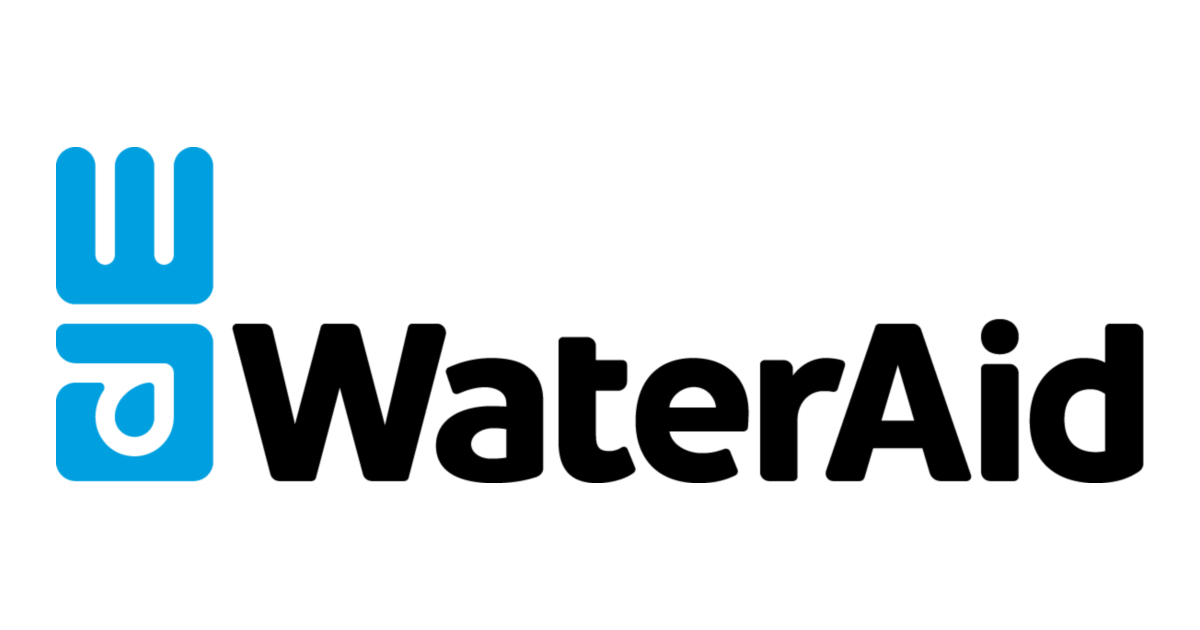

## Business Problem

In this project I work with the Tanzania Water Well data.

We are given the following prompt with this data set:

`Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.`

`Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Your audience could be an NGO focused on locating wells needing repair, or the Government of Tanzania looking to find patterns in non-functional wells to influence how new wells are built. Note that this is a ternary classification problem by default, but can be engineered to be binary.`

I am assuming the role of an analyst for a major NGO called WaterAid. They want to determine the best way to allocate their resources in Tanzania.

This notebook contains EDA, cleaning, and modeling processes for a Logistic Regression classifier model.

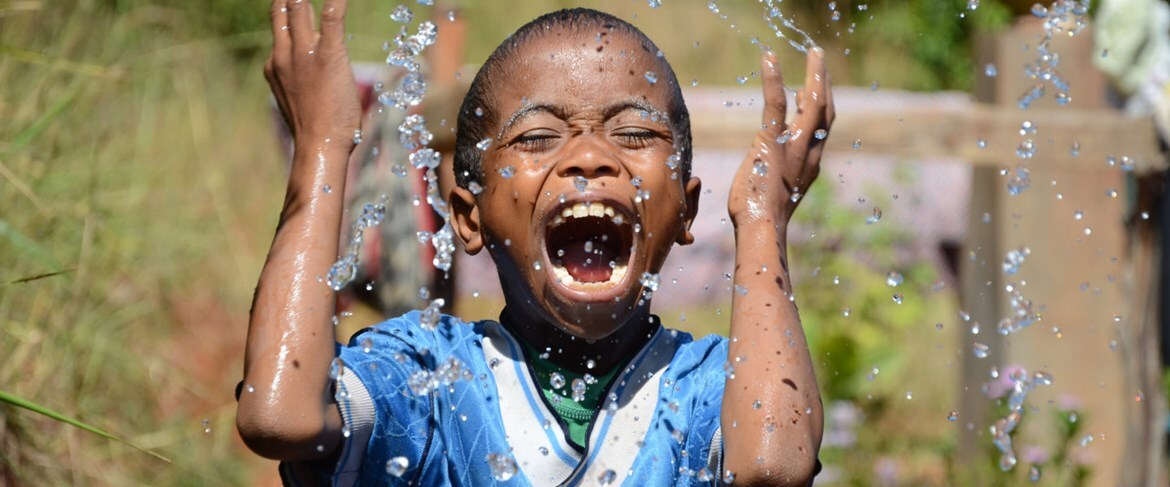

## Imports

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, log_loss

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

## EDA

This is section is basic EDA. I get a high level view of the data and combine them into one dataframe.

### Targets

Let's look at our targets first.

In [2]:
with open('./data/Tanzania_Training_Labels.csv') as f:
    target_df = pd.read_csv(f)

In [3]:
target_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
target_df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [5]:
target_df.shape

(59400, 2)

Okay, so we've got 3 categories here. Looks like we'll be doing ternary rather than binary classification. That doesn't change much for me, just that I'll need to replace these labels with [0, 1, 2] rather than just [0, 1].

In [6]:
# Encode the targets
target_df = target_df.replace({'status_group': {'non functional': 0,
                                                'functional': 1,
                                                'functional needs repair': 2}})

In [7]:
target_df.head()

,id,status_group
0,69572,1
1,8776,1
2,34310,1
3,67743,0
4,19728,1


### Features

Now let's load up the features we have on each well. This is what we'll load into our model as X variables.

In [8]:
with open('./data/Tanzania_Training_Values.csv') as f:
    df = pd.read_csv(f)

In [9]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Here's a data dictionary provided to us with the data set:

 - We show this dictionary below in the cleaning section. Removing here in final notebook for efficiency.

In [10]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [11]:
df.shape

(59400, 40)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Looks like we've got our work cut out for us on the data cleaning side. Thankfully we have the same number of records for features and targets. In our data cleaning process we will go column by column and get a better look at things, as well as decide how to deal with the data once we get to the model pre-processing.

### Merge and Save Down

Now let's merge for easy loading later.

In [13]:
merged_df = pd.merge(df, target_df, on='id')

In [14]:
# Not running in final notebook, already saved down from basic EDA.

# Save down merged data
# merged_df.to_csv('../data/Tanzania_Training_Merged.csv', index=False)

## Data Cleaning

### Load It Up!

Let's look at our targets first.

In [15]:
with open('./data/Tanzania_Training_Merged.csv') as f:
    df = pd.read_csv(f)

# Increase columns displayed so we can see    
pd.set_option('display.max_columns', 50)

In [16]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1


### Let's Get Cleaning

The plan is to go column by column and decide the following:
 - Should we keep this column?
 - Are there null values we need to handle?
 - How will we address this feature in pre-processing for the model?
     - If categorical, will likely need to encode
     - If numerical, will need to scale
     
We will be referencing this data dictionary, provided [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#the-features-in-this-dataset) with the dataset. 

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint
     
Here we go!

#### id

In [17]:
df.id.value_counts(dropna=False)

2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64

So we have one id per record. That adds up. We can remove this feature as the id number should have no bearing on well function.

In [18]:
# Drop ID
df = df.drop('id', axis=1)

#### amount_tsh

In [19]:
df.amount_tsh.describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [20]:
df.amount_tsh.value_counts(dropna=False)

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

Not normally distributed. We'll definitely want to scale this. Let's start a running list of numerical, categorical, binary, and dropped columns so we can add to them as we go and reference later.

We also note a significant number of 0 values here. We're going to assume these are actually missing values and replace them with NaN's.

In [21]:
# Create empty lists
num_columns = []
cat_columns = []
bin_columns = []
drop_columns = []

# Amount_tsh will go into numerical column list
num_columns.append('amount_tsh')

# Replace 0 with NaN
df = df.replace({'amount_tsh': {0: np.nan}})

#### date_recorded

In [22]:
df.date_recorded.max()

'2013-12-03'

In [23]:
df.date_recorded.min()

'2002-10-14'

So these records have been recorded between 2002 and 2013. That's nice to know, but thinking critically about this, we don't believe the date of observation should have any input on our model, especially since the unseen data we would like to make predictions for will not have observation dates listed.

In [24]:
# Drop date_recorded
df = df.drop('date_recorded', axis=1)
drop_columns.append('date_recorded')

#### funder and installer

In [25]:
df.funder.value_counts(dropna=False)

Government Of Tanzania         9084
NaN                            3635
Danida                         3114
Hesawa                         2202
Rwssp                          1374
                               ... 
Shabani Dunia                     1
Embasy Of Japan In Tanzania       1
Unice/ Cspd                       1
Lion Clu                          1
Muivaru                           1
Name: funder, Length: 1898, dtype: int64

In [26]:
df.installer.value_counts(dropna=False)

DWE                17402
NaN                 3655
Government          1825
RWE                 1206
Commu               1060
                   ...  
Anglikana              1
Villege Council        1
Bao                    1
malola                 1
AFRICA MUSLIM          1
Name: installer, Length: 2146, dtype: int64

We've got way too many categories here to encode fully. Plus, all the single-instance categories wouldn't give us any significant predictive signal to analyze. Let's replace any category with less than 100 instances with 'Other'.

In [27]:
# Create list of funders with less than 100 appearances
low_count_funders = df.funder.value_counts()[df.funder.value_counts() < 100].index.tolist()

# Use mask function to replace funders in this list with 'Other'
df.funder.mask(df.funder.isin(low_count_funders), 'Other', inplace=True)

In [28]:
# Do the same for installers
low_count_installers = df.installer.value_counts()[df.installer.value_counts() < 100].index.tolist()

df.installer.mask(df.installer.isin(low_count_installers), 'Other', inplace=True)

In [29]:
df.funder.value_counts(dropna=False)

Other                            12379
Government Of Tanzania            9084
NaN                               3635
Danida                            3114
Hesawa                            2202
                                 ...  
Ru                                 105
Village Council                    105
Halmashauri Ya Wilaya Sikonge      102
Germany                            101
Hsw                                101
Name: funder, Length: 93, dtype: int64

In [30]:
df.installer.value_counts(dropna=False)

DWE                              17402
Other                            13545
NaN                               3655
Government                        1825
RWE                               1206
                                 ...  
WATER AID                          103
FINI WATER                         103
Halmashauri ya wilaya sikonge      102
HSW                                100
Wizara ya maji                     100
Name: installer, Length: 86, dtype: int64

Great! We're not sure if these will be useful, but maybe! Let's throw them in our categorical column list.

In [31]:
cat_columns.append('funder')
cat_columns.append('installer')

#### gps_height

In [32]:
df.gps_height.describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

In [33]:
df.gps_height.value_counts(dropna=False)

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

A bit of the same issue as the tsh_amount column. Lot's of 0's. Let's replace with NaN's and throw it in our numeric group.

In [34]:
# Replace 0 with NaN
df = df.replace({'gps_height': {0: np.nan}})

# gps_height will go into numerical column list
num_columns.append('gps_height')

#### longitude, latitude

In [35]:
df.longitude.value_counts(dropna=False)

0.000000     1812
39.088875       2
39.105307       2
37.543401       2
38.180538       2
             ... 
38.710520       1
40.117029       1
34.672962       1
39.433604       1
34.890838       1
Name: longitude, Length: 57516, dtype: int64

In [36]:
df.latitude.value_counts(dropna=False)

-2.000000e-08    1812
-6.990549e+00       2
-2.489378e+00       2
-2.515321e+00       2
-6.963565e+00       2
                 ... 
-1.086099e+01       1
-3.149066e+00       1
-3.305834e+00       1
-9.076967e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

We found some hidden nulls in longitude and latitude. Let's recode those as NaN's and then add these to the numeric columns. We will impute these later and create a missing indicator.

In [37]:
df = df.replace({'longitude': {0: np.nan},
            'latitude': {-2e-08: np.nan}})

In [38]:
# longitude and latitude will go into numerical column list
num_columns.append('longitude')
num_columns.append('latitude')

#### wpt_name

In [39]:
df.wpt_name.value_counts(dropna=False)

none                   3563
Shuleni                1748
Zahanati                830
Msikitini               535
Kanisani                323
                       ... 
Misugusugu Zahanati       1
Kwa Musalenge             1
Kemugesi                  1
Kwawilsoni                1
Kwa Wiliam Simon          1
Name: wpt_name, Length: 37400, dtype: int64

We'll drop this column as a name shouldn't have any predictive power. 

In [40]:
# Drop wpt_name
df = df.drop('wpt_name', axis=1)
drop_columns.append('wpt_name')

#### num_private

In [41]:
df.num_private.value_counts(dropna=False)

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

The data dictionary doesn't have any info on this column, and it's extremely concentrated at zero anyways. Drop.

In [42]:
# Drop num_private
df = df.drop('num_private', axis=1)
drop_columns.append('num_private')

#### basin

In [43]:
df.basin.value_counts(dropna=False)

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

A good categorical column. Let's add it to the list. We'll have to One Hot Encode this one. 

In [44]:
cat_columns.append('basin')

#### subvillage, region, region_code, district_code, lga, ward

According to the data dictionary, all of these features are for geographic location. We definitely want to use these, but let's pick the most useful looking ones.

In [45]:
df.subvillage.value_counts(dropna=False)

Madukani          508
Shuleni           506
Majengo           502
Kati              373
NaN               371
                 ... 
Kiti Cha Mungu      1
Kukagerege          1
Endarag             1
Dododma             1
Bumbul7             1
Name: subvillage, Length: 19288, dtype: int64

In [46]:
df.region.value_counts(dropna=False)

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [47]:
df.region_code.value_counts(dropna=False)

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [48]:
df.district_code.value_counts(dropna=False)

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [49]:
df.lga.value_counts(dropna=False)

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [50]:
df.ward.value_counts(dropna=False)

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Izia           1
Korongoni      1
Themi          1
Kirongo        1
Uchindile      1
Name: ward, Length: 2092, dtype: int64

Our first time through, we only picked 2 of these 6. We see now that we aren't even close to overfitting, so we're going to feed all of these to our model. First, let's replace any categories with less than 100 instances with other, then append all of them to the categorical columns.

In [51]:
# Create list of subvillages with less than 100 appearances
low_count_subvillage = df.subvillage.value_counts()[df.subvillage.value_counts() < 100].index.tolist()

# Use mask function to replace subvillages in this list with 'Other'
df.subvillage.mask(df.subvillage.isin(low_count_subvillage), 'Other', inplace=True)

# Same for lga and ward

low_count_lga = df.lga.value_counts()[df.lga.value_counts() < 100].index.tolist()
df.lga.mask(df.lga.isin(low_count_lga), 'Other', inplace=True)

low_count_ward = df.ward.value_counts()[df.ward.value_counts() < 100].index.tolist()
df.ward.mask(df.ward.isin(low_count_ward), 'Other', inplace=True)

In [52]:
cat_columns.append('subvillage')
cat_columns.append('region_code')
cat_columns.append('region')
cat_columns.append('district_code')
cat_columns.append('lga')
cat_columns.append('ward')

#### population

In [53]:
df.population.value_counts(dropna=False)

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

Again, a huge concentration of near-zero numbers. We don't buy that 21k wells have no one around. We also don't buy that 7k have only 1 person, for that matter. We're going to replace those with NaN's and put this in the numeric list.

In [54]:
df = df.replace({'population': {0: np.nan,
                               1: np.nan}})

num_columns.append('population')

#### public_meeting

In [55]:
df.public_meeting.value_counts(dropna=False)

True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64

We're not entirely sure what this one is, but we feel comfortable leaving it in. This is a binary categorical classifier. We will want to treat this differently than our other categoricals because it doesn't need to be one hot encoded to be useful to our Logistic Regressor.

In [56]:
bin_columns.append('public_meeting')

#### recorded_by

In [57]:
df.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

Only one value, not predictive!

In [58]:
# Drop recorded_by
df = df.drop('recorded_by', axis=1)
drop_columns.append('recorded_by')

#### scheme_management and scheme_name

The data dictionary describes both of these features as "who operates the waterpoint". Let's try and pick one.

In [59]:
df.scheme_management.value_counts(dropna=False)

VWC                 36793
WUG                  5206
NaN                  3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [60]:
df.scheme_name.value_counts(dropna=False)

NaN                       28166
K                           682
None                        644
Borehole                    546
Chalinze wate               405
                          ...  
Kabaheshi pring source        1
TCRS                          1
Ung'oro Water supply          1
ADP Simbu                     1
Ugalla water supply           1
Name: scheme_name, Length: 2697, dtype: int64

Okay, we're definitely going with scheme_management. That's a clean categorical. We should also replace the 'none' value with a NaN.

In [61]:
# Replace None in scheme_management with Nan
df = df.replace({'scheme_management': {'None': np.nan}})
cat_columns.append('scheme_management')
                 
# Drop scheme_name
df = df.drop('scheme_name', axis=1)
drop_columns.append('scheme_name')

#### Permit

In [62]:
df.permit.value_counts(dropna=False)

True     38852
False    17492
NaN       3056
Name: permit, dtype: int64

Binary!

In [63]:
bin_columns.append('permit')

#### construction_year

In [64]:
df.construction_year.value_counts(dropna=False)

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

This one is tricky for us as a beginner ML practitioner. Our first instinct is to treat it as numeric, but really it's categorical. Let's replace those 0's with NaN's and throw it in the categorical list.

In [65]:
df = df.replace({'construction_year': {0: np.nan}})
cat_columns.append('construction_year')

#### extraction_type, extraction_type_group, extraction_type_class

These look very similar to each other. The dictionary gives the same description for each as "the kind of extraction the waterpoint uses". Let's try and pick just one again.

In [66]:
df.extraction_type.value_counts(dropna=False)

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [67]:
df.extraction_type_group.value_counts(dropna=False)

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [68]:
df.extraction_type_class.value_counts(dropna=False)

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

Okay, so each one is a bit more granular than the other. The most granular has a few categories with too few values for us to be comfortable with. If we chose the least granular, we would be worried about potentially losing some important signals coming from the type of pump. Let's go with extraction_type_group and drop the other 2.

In [69]:
cat_columns.append('extraction_type_group')

df = df.drop('extraction_type', axis=1)
df = df.drop('extraction_type_class', axis=1)
drop_columns.append('extraction_type')
drop_columns.append('extraction_type_class')

#### management and management_group

These look very similar to our scheme columns. We may not need these at all.

In [70]:
df.management.value_counts(dropna=False)

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [71]:
df.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

The management_group is less granular, so we know we would get a better signal from the management feature. But it looks very close to our scheme_management feature...

In [72]:
df.scheme_management.value_counts(dropna=False)

VWC                 36793
WUG                  5206
NaN                  3878
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

Close, but not the same. That makes sense when we think about it. There could be many wells operated by one group and managed by another. Let's drop management_group and keep management.

In [73]:
cat_columns.append('management')

df = df.drop('management_group', axis=1)
drop_columns.append('management_group')

#### payment and payment_type

In [74]:
df.payment.value_counts(dropna=False)

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [75]:
df.payment_type.value_counts(dropna=False)

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

Clear duplicates! Nice. We will keep payment_type because we like the slightly shorter string values given for the categories.

In [76]:
cat_columns.append('payment_type')

df = df.drop('payment', axis=1)
drop_columns.append('payment')

#### water_quality and quality_group

In [77]:
df.water_quality.value_counts(dropna=False)

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [78]:
df.quality_group.value_counts(dropna=False)

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

Let's go with water_quality for the extra level of granularity!

In [79]:
cat_columns.append('water_quality')

df = df.drop('quality_group', axis=1)
drop_columns.append('quality_group')

#### quantity and quantity_group

In [80]:
df.quantity.value_counts(dropna=False)

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [81]:
df.quantity_group.value_counts(dropna=False)

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

Copies! Let's go with quantity for the briefer name.

In [82]:
cat_columns.append('quantity')

df = df.drop('quantity_group', axis=1)
drop_columns.append('quantity_group')

#### source, source_type, source_class

Another group of features with the same description in the dictionary. Who will win?

In [83]:
df.source.value_counts(dropna=False)

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [84]:
df.source_type.value_counts(dropna=False)

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [85]:
df.source_class.value_counts(dropna=False)

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

We like the granularity given with the source feature. We can accept 66 in the least frequent class as it is an unknown, and we'd like to see lake/river broken out as well as machine/hand drilled wells.

In [86]:
cat_columns.append('source')

df = df.drop('source_type', axis=1)
df = df.drop('source_class', axis=1)
drop_columns.append('source_type')
drop_columns.append('source_class')

#### waterpoint_type and waterpoint_type_group

And last but not least! Dealer's choice.

In [87]:
df.waterpoint_type.value_counts(dropna=False)

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [88]:
df.waterpoint_type_group.value_counts(dropna=False)

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

A tiny bit more detail with waterpoint_type. Let's go with it.

In [89]:
cat_columns.append('waterpoint_type')

df = df.drop('waterpoint_type_group', axis=1)
drop_columns.append('waterpoint_type_group')

### What's left?

In [90]:
df.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type_group,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group
0,6000.0,Roman,1390.0,Other,34.938093,-9.856322,Lake Nyasa,Other,Iringa,11,5,Ludewa,Other,109.0,True,VWC,False,1999.0,gravity,vwc,annually,soft,enough,spring,communal standpipe,1
1,NaN,Other,1399.0,Other,34.698766,-2.147466,Lake Victoria,Other,Mara,20,2,Serengeti,Other,280.0,NaN,Other,True,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,1
2,25.0,Other,686.0,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,21,4,Simanjiro,Other,250.0,True,VWC,True,2009.0,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,1
3,NaN,Unicef,263.0,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Other,Mtwara,90,63,Nanyumbu,Other,58.0,True,VWC,True,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,0
4,NaN,Other,NaN,Artisan,31.130847,-1.825359,Lake Victoria,Other,Kagera,18,1,Karagwe,Other,NaN,True,NaN,True,NaN,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,1


In [91]:
df_cleaned = df

So for our numeric columns, we will be scaling and creating some Null indicator categories.

In [92]:
num_columns

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population']

And we'll One Hot Encode all these categorical columns. We'll also create Null indicators here and use Simple Imputer on any NaN's.

In [93]:
cat_columns

['funder',
 'installer',
 'basin',
 'subvillage',
 'region_code',
 'region',
 'district_code',
 'lga',
 'ward',
 'scheme_management',
 'construction_year',
 'extraction_type_group',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

We just need to impute these and they will be model-ready.

In [94]:
bin_columns

['public_meeting', 'permit']

And for easy reference later, here are the columns we dropped.

In [95]:
drop_columns

['date_recorded',
 'wpt_name',
 'num_private',
 'recorded_by',
 'scheme_name',
 'extraction_type',
 'extraction_type_class',
 'management_group',
 'payment',
 'quality_group',
 'quantity_group',
 'source_type',
 'source_class',
 'waterpoint_type_group']

### Save Down

In [96]:
# Not running here as we saved down in our Cleaning notebook already
# df_cleaned.to_csv('../data/Tanzania_Training_Cleaned.csv', index=False)

## Modeling

### Load in Data

In [97]:
with open('./data/Tanzania_Training_Cleaned.csv') as f:
    df = pd.read_csv(f)
    
# Copy and paste column lists from Cleaning notebook
num_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population']
cat_cols = ['funder', 'installer', 'basin', 'subvillage', 'region', 'region_code', 
            'district_code', 'lga', 'ward', 'scheme_management', 'construction_year', 
            'extraction_type_group', 'management', 'payment_type', 'water_quality', 
            'quantity', 'source', 'waterpoint_type']
bin_cols = ['public_meeting', 'permit']

### Basic Understanding

In [98]:
df.shape

(59400, 26)

In [99]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,status_group
count,17761.000000,38962.000000,57588.000000,57588.000000,59400.000000,59400.000000,30994.000000,38691.000000,59400.000000
mean,1062.351942,1018.860839,35.149669,-5.885572,15.297003,5.629747,344.570820,1996.814686,0.688434
std,5409.344940,612.566092,2.607428,2.809876,17.587406,9.633649,607.731177,12.472045,0.599877
min,0.200000,-90.000000,29.607122,-11.649440,1.000000,0.000000,2.000000,1960.000000,0.000000
25%,50.000000,393.000000,33.285100,-8.643841,5.000000,2.000000,100.000000,1987.000000,0.000000
50%,250.000000,1167.000000,35.005943,-5.172704,12.000000,3.000000,200.000000,2000.000000,1.000000
75%,1000.000000,1498.000000,37.233712,-3.372824,17.000000,5.000000,380.000000,2008.000000,1.000000
max,350000.000000,2770.000000,40.345193,-0.998464,99.000000,80.000000,30500.000000,2013.000000,2.000000


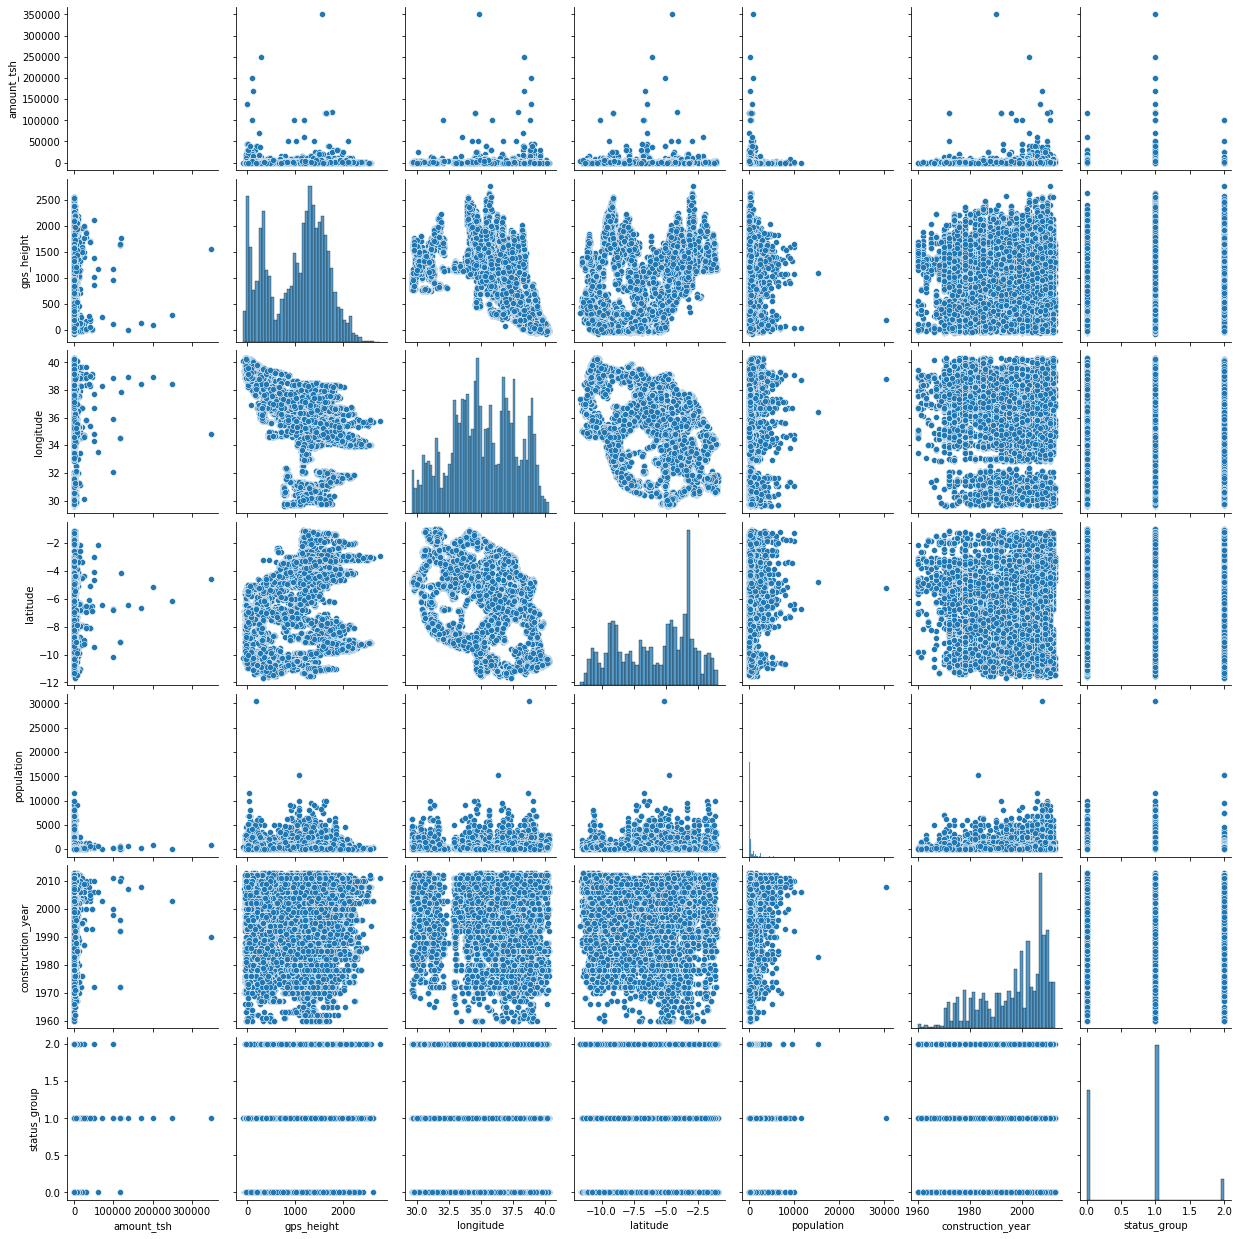

In [100]:
sns.pairplot(df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 
                 'population', 'construction_year', 'status_group']]);

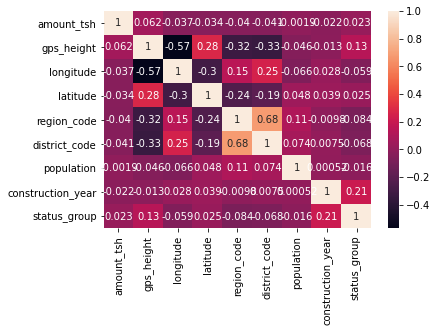

In [101]:
sns.heatmap(df.corr(), annot=True);

No major correlations to note.

### Train Test Split

In [102]:
X = df.drop('status_group', axis=1)
y = df.status_group
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Dummy Model

In [103]:
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

In [104]:
dummy_model.score(X_train, y_train)

0.542334455667789

In [105]:
y_train.value_counts(normalize=True)

1    0.542334
0    0.384871
2    0.072795
Name: status_group, dtype: float64

So, our dummy model is 54.2% accurate by simply predicting the most frequent class. That's the number to beat with our next model.

### Model Evaluation Class

Before going further, let's build a model evaluation function that we can use for each iteration. For this code, we start with the function `ModelWithCV()` used in lecture 41 and tweak it for our use.

In [106]:
class ModelEvaluation():
    
    def __init__(self, model, model_name, X, y):
        self.model = model
        self.name = model_name
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(X, y, random_state=42)
        
        # Attributes for cross validation
        self.cv_results = None
        self.cv_mean = None
        self.cv_std = None
        
        # Attributes for accuracy and loss summary
        self.training_accuracy = model.score(self.X_train, self.y_train)
        self.testing_accuracy = model.score(self.X_test, self.y_test)
        self.training_loss = log_loss(self.y_train, model.predict_proba(self.X_train)) 
        self.testing_loss = log_loss(self.y_test, model.predict_proba(self.X_test))
        
        # Attributes for confusion matrix summary
        self.functional_recall = None
        self.non_functional_recall = None
        self.needs_repair_recall = None
        
    # This is an accuracy and loss summary for both the train and test data
    def summary(self):
        eval_summary = (f'''
        Training accuracy: {self.training_accuracy:.2%}
        Training loss: {self.training_loss:.2f}
        Testing accuracy: {self.testing_accuracy:.2%}
        Testing loss: {self.testing_loss:.2f}
        ''')
        print(eval_summary)
        
    # Runs cross validation and prints summary
    def cross_validate(self, kfolds=5):
        cv_X = self.X_train
        cv_y = self.y_train

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

    # Plots confusion matrix for the test data and saves down in images folder
    def plot_cm(self):
        fig, ax = plt.subplots(figsize=(7, 7))
        # Sets transparent background for use in presentation
        fig.patch.set_facecolor('none')
        
        ax.set_title(f'Confusion Matrix for `{self.name}` Model')
        
        plot_confusion_matrix(self.model, self.X_test, self.y_test, ax=ax, cmap='PuBu')
        
        fig.savefig(f'./images/{self.name}_CM');
    
    # Summary of accuracy of class predictions for testing data
    def cm_summary(self):
        cm = confusion_matrix(self.y_test, self.model.predict(self.X_test))
        
        # Defines recall for each class
        self.functional_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1] + cm[1, 2])
        self.non_functional_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
        self.needs_repair_recall = cm[2, 2] / (cm[2, 0] + cm[2, 1] + cm[2, 2])
        
        cm_summary = (f'''
        Functional recall: {self.functional_recall:.2%} 
        Non-Functional recall: {self.non_functional_recall:.2%} 
        Needs Repair recall: {self.needs_repair_recall:.2%}
        ''')
        print(cm_summary)

Let's test this out on our Dummy Model.

In [107]:
dummy_eval = ModelEvaluation(
    model = dummy_model,
    model_name = 'Dummy',
    X = X,
    y = y
)

In [108]:
dummy_eval.summary()


        Training accuracy: 54.23%
        Training loss: 15.81
        Testing accuracy: 54.53%
        Testing loss: 15.70
        


In [109]:
dummy_eval.cross_validate()

CV Results for `Dummy` model:
            0.54233 ± 0.00004 accuracy
        


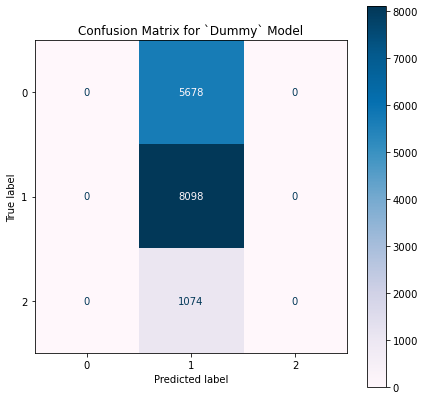

In [110]:
dummy_eval.plot_cm()

In [111]:
dummy_eval.cm_summary()


        Functional recall: 100.00% 
        Non-Functional recall: 0.00% 
        Needs Repair recall: 0.00%
        


Sweet! This will be very useful to get a sense of our models' relative performance.

### First Simple Model

Let's get some sub-pipelines going for our Numeric and Categorical features. We need to impute any nulls for both types. For this first model, we will scale our numerics and one hot encode our categoricals.

In [112]:
# Numeric columns sub-pipeline
num_sub_pipe = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean', add_indicator=True)),
    ('ss', StandardScaler())
])

# Categorical columns sub-pipeline
cat_sub_pipe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
])

# Binary columns sub-pipeline
bin_sub_pipe = Pipeline(steps=[
    ('bin_impute', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

# Column Transformer
ct = ColumnTransformer(transformers=[
    ('numerics', num_sub_pipe, num_cols),
    ('categoricals', cat_sub_pipe, cat_cols),
    ('binary', bin_sub_pipe, bin_cols)
])

In [113]:
# First Simple Model
fsm_pipe = Pipeline(steps=[
    ('ct', ct),
    ('fsm', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

In [114]:
fsm_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('numerics',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'population']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_freq

In [115]:
fsm_eval = ModelEvaluation(
    model = fsm_pipe,
    model_name = 'Simple_LogReg',
    X = X,
    y = y
)

In [116]:
fsm_eval.summary()


        Training accuracy: 76.68%
        Training loss: 0.57
        Testing accuracy: 75.88%
        Testing loss: 0.58
        


In [117]:
fsm_eval.cross_validate()

CV Results for `Simple_LogReg` model:
            0.75865 ± 0.00445 accuracy
        


Wow! Big improvement over our baseline dummy model. And the loss isn't bad either.

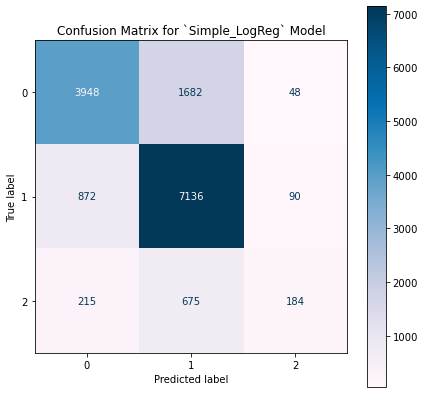

In [118]:
fsm_eval.plot_cm()

In [119]:
fsm_eval.cm_summary()


        Functional recall: 88.12% 
        Non-Functional recall: 69.53% 
        Needs Repair recall: 17.13%
        


We could definitely improve our recall for the non_functional and needs repair categories. Let's add a polynomial features transformer to the pipeline and see what happens.

### Adding in Polynomials

In [120]:
# New numerics sub-pipeline with polynomial features
poly_num_sub_pipe = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean', add_indicator=True)),
    ('poly', PolynomialFeatures(degree=2)),
    ('ss', StandardScaler())
])

# New Column Transformer with our new poly_num_sub_pipe
poly_ct = ColumnTransformer(transformers=[
    ('poly_numerics', poly_num_sub_pipe, num_cols),
    ('categoricals', cat_sub_pipe, cat_cols),
    ('binary', bin_sub_pipe, bin_cols)
])

In [121]:
# First Polynomial Model
first_poly_pipe = Pipeline(steps=[
    ('ct', poly_ct),
    ('lr', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

In [122]:
first_poly_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('poly_numerics',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'population']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_impute',
                               

In [123]:
poly_eval = ModelEvaluation(
    model = first_poly_pipe,
    model_name = 'Polynomial',
    X = X,
    y = y
)

In [124]:
poly_eval.summary()


        Training accuracy: 76.37%
        Training loss: 0.57
        Testing accuracy: 75.49%
        Testing loss: 0.58
        


In [125]:
poly_eval.cross_validate()

CV Results for `Polynomial` model:
            0.75809 ± 0.00278 accuracy
        


Darn, just slightly worse.

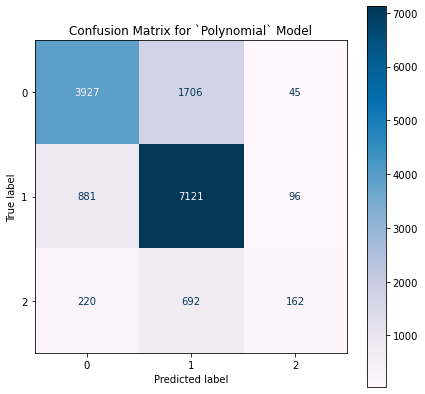

In [126]:
poly_eval.plot_cm()

In [127]:
poly_eval.cm_summary()


        Functional recall: 87.94% 
        Non-Functional recall: 69.16% 
        Needs Repair recall: 15.08%
        


A little worse recall for our minority classes, too. Let's try to oversample those and see if we can improve that. And skip the polynomial features, too.

### SMOTE?

In [128]:
smote_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(random_state=42)),
    ('lr', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

In [129]:
smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('numerics',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'population']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_freq

In [130]:
smote_eval = ModelEvaluation(
    model = smote_pipe,
    model_name = 'LogReg_SMOTE',
    X = X,
    y = y
)

In [131]:
smote_eval.summary()


        Training accuracy: 67.75%
        Training loss: 0.71
        Testing accuracy: 66.28%
        Testing loss: 0.74
        


In [132]:
smote_eval.cross_validate()

CV Results for `LogReg_SMOTE` model:
            0.66676 ± 0.00509 accuracy
        


Accuracy down, loss slightly up. But what about our recall scores?

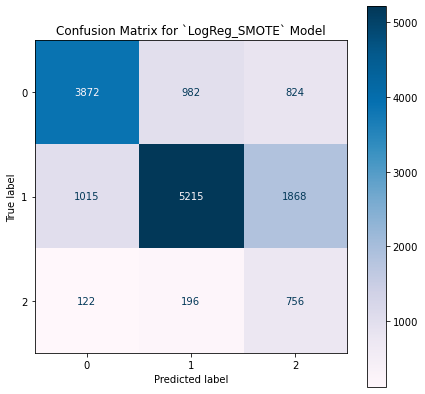

In [133]:
smote_eval.plot_cm()

In [134]:
smote_eval.cm_summary()


        Functional recall: 64.40% 
        Non-Functional recall: 68.19% 
        Needs Repair recall: 70.39%
        


Interesting. We were much less accurate at identifying the functional wells, but made significant improvement in the recall of wells that are functional but need repair. Non-functional wells are about the same. 

We might be okay with this trade-off. Faulty wells put lives at risk, and although we may spend money visiting more wells labeled faulty that are actually functional, we will also be able to fix a larger portion of the faulty wells.

In this case, however, since our non-functional recall is about the same (in fact, just slightly worse), we are going to opt for the non-Smote model.

### Grid Search

Let's do one last iteration and grid search on our simple Logistic Regression model.

In [135]:
pd.DataFrame.from_dict(fsm_pipe.get_params(), orient='index').index

Index(['memory', 'steps', 'verbose', 'ct', 'fsm', 'ct__n_jobs',
       'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights',
       'ct__transformers', 'ct__verbose', 'ct__numerics', 'ct__categoricals',
       'ct__binary', 'ct__numerics__memory', 'ct__numerics__steps',
       'ct__numerics__verbose', 'ct__numerics__num_impute', 'ct__numerics__ss',
       'ct__numerics__num_impute__add_indicator',
       'ct__numerics__num_impute__copy',
       'ct__numerics__num_impute__fill_value',
       'ct__numerics__num_impute__missing_values',
       'ct__numerics__num_impute__strategy',
       'ct__numerics__num_impute__verbose', 'ct__numerics__ss__copy',
       'ct__numerics__ss__with_mean', 'ct__numerics__ss__with_std',
       'ct__categoricals__memory', 'ct__categoricals__steps',
       'ct__categoricals__verbose', 'ct__categoricals__cat_impute',
       'ct__categoricals__ohe', 'ct__categoricals__cat_impute__add_indicator',
       'ct__categoricals__cat_impute__copy',
       'c

In [136]:
params = {
    'ct__numerics__num_impute__strategy' : ['mean', 'median'],
    'fsm__solver' : ['newton-cg', 'sag', 'lbfgs'],
    'fsm__max_iter': [100, 1000, 10000],
    'fsm__C' : [1, 10, 100],
    'fsm__tol' : [0.0001, 0.001, 0.01]}

In [137]:
gs = GridSearchCV(
    estimator = fsm_pipe,
    param_grid = params,
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [138]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 48.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('numerics',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'longitude',
                                                                          'latitude',
                                                                

In [139]:
gs.best_params_

{'ct__numerics__num_impute__strategy': 'mean',
 'fsm__C': 100,
 'fsm__max_iter': 10000,
 'fsm__solver': 'sag',
 'fsm__tol': 0.001}

In [140]:
gs_best = gs.best_estimator_

In [141]:
gs_eval = ModelEvaluation(
    model = gs_best,
    model_name = 'LogReg_GridSearch',
    X = X,
    y = y
)

In [142]:
gs_eval.summary()


        Training accuracy: 76.67%
        Training loss: 0.57
        Testing accuracy: 75.97%
        Testing loss: 0.58
        


In [143]:
gs_eval.cross_validate()

CV Results for `LogReg_GridSearch` model:
            0.76000 ± 0.00289 accuracy
        


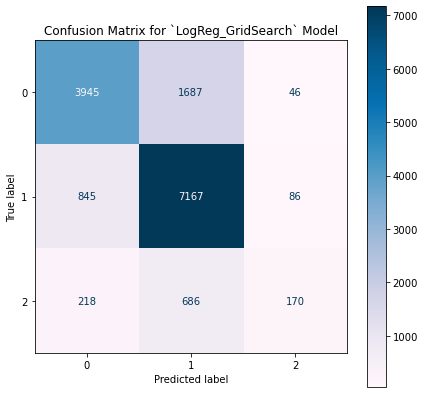

In [144]:
gs_eval.plot_cm()

In [145]:
gs_eval.cm_summary()


        Functional recall: 88.50% 
        Non-Functional recall: 69.48% 
        Needs Repair recall: 15.83%
        


## Model Comparison and Evaluation

In [146]:
model_scores = [dummy_eval, fsm_eval, poly_eval, smote_eval, gs_eval]

final_scores_dict = {
    "Model Name": [i.name for i in model_scores],
    "Training Accuracy": [i.training_accuracy for i in model_scores], 
    "Training Loss": [i.training_loss for i in model_scores], 
    "Testing Accuracy": [i.testing_accuracy for i in model_scores], 
    "Testing Loss": [i.testing_loss for i in model_scores], 
    "Functional Recall": [i.functional_recall for i in model_scores], 
    "Non-Functional Recall": [i.non_functional_recall for i in model_scores], 
    "Needs Repair Recall": [i.needs_repair_recall for i in model_scores]
}
final_scores_df = pd.DataFrame(final_scores_dict).set_index('Model Name')

final_scores_df

,Training Accuracy,Training Loss,Testing Accuracy,Testing Loss,Functional Recall,Non-Functional Recall,Needs Repair Recall
Model Name,,,,,,,
Dummy,0.542334,15.807208,0.545320,15.704096,1.000000,0.000000,0.000000
Simple_LogReg,0.766779,0.567054,0.758788,0.583648,0.881205,0.695315,0.171322
Polynomial,0.763704,0.571156,0.754882,0.584802,0.879353,0.691617,0.150838
LogReg_SMOTE,0.677486,0.713795,0.662828,0.739463,0.643986,0.681930,0.703911
LogReg_GridSearch,0.766712,0.569033,0.759731,0.583107,0.885033,0.694787,0.158287


### Evaluation / Conclusion

Our final recommendation is to use either the Logistic Regression with Grid Search or the Logistic Regression with SMOTE.

The Grid Search model has the highest accuracy when applied to the testing data and will lead to the most efficient use of resources. In other words, if WaterAid decides to visit wells predicted to be Non-Functional or Needing Repair, the Grid Search model will be the least likely to point them to an actually Functional well, which would result in a waste of resources.

However, the SMOTE model has the highest recall for the Needs Repair class, which is terribly low for the non-SMOTE models. By visiting wells predicted to be faulty using this model, WaterAid will fix more of the actually faulty models, at the expense of spending more money visiting wells that don't need fixing.

If budget allows, we would recommend first visiting all of the wells labeled faulty by the Grid Search model, then expanding the search using the SMOTE model.

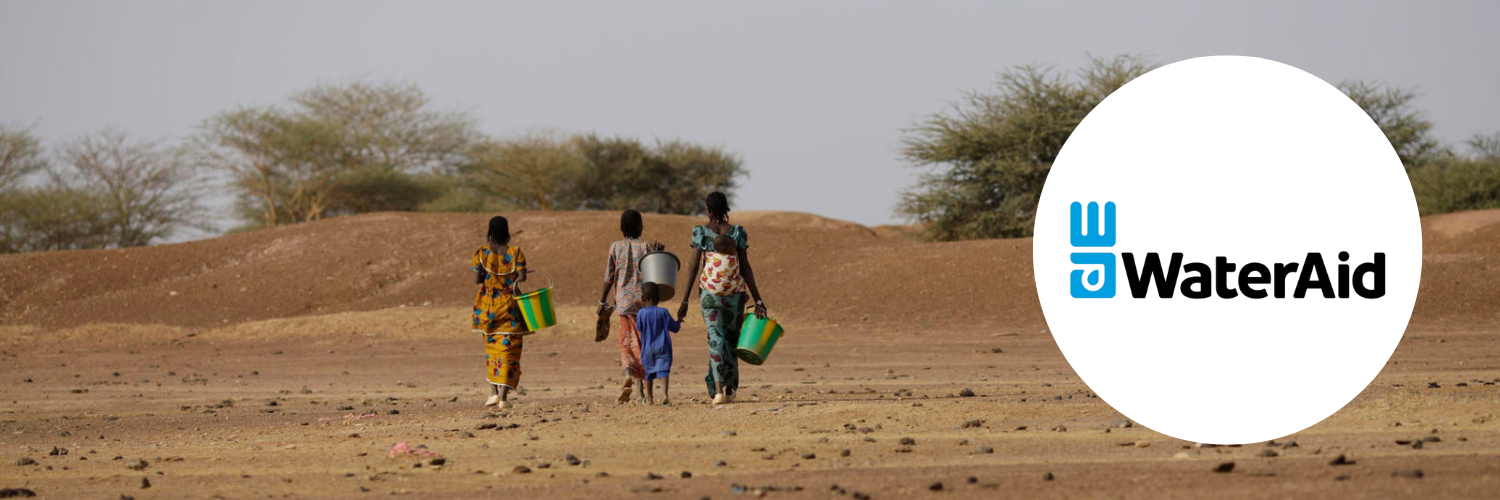